# Time Series Modelling and Predictions using Zillow Real Estate Data


# Some Notes Before Starting


## Wide Format vs Long Format



<img src='~/../images/melted1.png'>


# Helper Functions Provided



# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [2]:
#!pip install -U fsds_100719

In [3]:
from fsds_100719.imports import *

pd.set_option('display.max_columns',0)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-notebook')


fsds_1007219  v0.6.4 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [7]:
#df = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-online-ds-ft-10072019/master/zillow_data.csv')
df = pd.read_csv('zillow_data.csv')
df.head().style.set_caption("Original Wide Format")

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200,335400,336500,337600,338500,339500,340400,341300,342600,344400,345700,346700,347800,349000,350400,352000,353900,356200,358800,361800,365700,370200,374700,378900,383500,388300,393300,398500,403800,409100,414600,420100,426200,432600,438600,444200,450000,455900,462100,468500,475300,482500,490200,498200,507200,516800,526300,535300,544500,553500,562400,571200,579800,588100,596300,604200,612200,620200,627700,634500,641000,647000,652700,658100,663300,668400,673400,678300,683200,688300,693300,698000,702400,706400,710200,714000,717800,721700,725700,729900,733400,735600,737200,739000,740900,742700,744400,746000,747200,748000,749000,750200,752300,755300,759200,764000,769600,775600,781900,787900,793200,798200,803100,807900,812900,818100,823100,828300,834100,839800,845600,851800,858000,864400,870700,876200,880700,884400,887600,890500,893300,895500,897300,899000,900400,902000,904400,907100,909700,911900,913000,913000,912000,909300,905300,901400,897900,895400,893600,891100,887000,881700,875900,870300,865100,859000,851500,843800,836400,830700,827300,824800,821600,818300,814600,809800,803600,795500,786900,780700,776900,774700,774200,774400,774600,775600,777800,775200,767900,764700,766100,764100,759700,754900,746200,737300,730800,729300,730200,730700,730000,730100,730100,731200,733900,735500,735400,734400,737500,737700,733700,734000,740300,744600,750500,760400,771800,780600,787900,794100,798900,802300,806100,810900,817400,826800,837900,848100,853800,856700,856600,854400,853000,856200,859700,863900,872900,883300,889500,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,9991

In [8]:
import functions_mod4proj as ji
help(ji)

Help on module functions_mod4proj:

NAME
    functions_mod4proj

FUNCTIONS
    get_model_metrics(true, preds, train, explain_U=False)
    
    get_train_test_split_index(ts, TEST_SIZE=0.2)
    
    make_dateindex(df_to_add_index, index_col='Month', index_name='date', drop=True, freq=None, verbose=True)
    
    melt_data(df)
    
    meta_grid_search(ts, TEST_SIZE=0.2, model_kws={}, verbose=True, return_kws=False)
    
    plotly_timeseries(df, x='datetime', y='MeanValue', color='RegionID', line_group='State')
    
    stationarity_check(TS, plot=True, col=None)
        From: https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/time-series-decomposition
    
    thiels_U(ys_true=None, ys_pred=None, display_equation=True, display_table=True)
        Calculate's Thiel's U metric for forecasting accuracy.
        Accepts true values and predicted values.
        Returns Thiel's U

FILE
    c:\users\

In [9]:
def melt_data(df):
    melted = pd.melt(df, id_vars = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
                                    'SizeRank'],var_name = 'Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset = ['MeanValue'])
    return melted



In [10]:
df = melt_data(df)
df.head().style.set_caption("MELTED LONG FORMAT")

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01 00:00:00,334200
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01 00:00:00,235700
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01 00:00:00,210400
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01 00:00:00,498100
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01 00:00:00,77300


# Step 2: Data Preprocessing

In [11]:
def make_dateindex(df, index_col='Month', drop = False, verbose = True):

    
    # Make datetime column which will become the index
    df[index_col] = pd.to_datetime(df[index_col], errors = 'coerce')
    
    
    # assign index
    df = df.set_index('Month', drop = drop)
    
    # Ask about what this means
    
    if verbose:
        display(df.index)
    return df

df = make_dateindex(df)
df

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=3744704, freq=None)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
1996-04-01,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
1996-04-01,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
1996-04-01,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0


In [12]:
df = df.rename(columns = {'Month':'Date',})
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [13]:
# Select the counties in California, where most people move to from San Francisco
df_sf_county = df.loc[df['CountyName'] == 'San Francisco']
len(df_sf_county)

5035

In [14]:
df_sf_county.head()
    
    

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0
1996-04-01,97565,94110,San Francisco,CA,San Francisco,San Francisco,77,1996-04-01,213900.0
1996-04-01,97576,94122,San Francisco,CA,San Francisco,San Francisco,334,1996-04-01,278400.0
1996-04-01,97567,94112,San Francisco,CA,San Francisco,San Francisco,505,1996-04-01,210100.0
1996-04-01,97569,94115,San Francisco,CA,San Francisco,San Francisco,743,1996-04-01,794000.0


In [15]:
df_sf_county.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
Date          0
MeanValue     0
dtype: int64

In [16]:
df_sf_county['RegionName'].nunique()

19

In [19]:
sf_city = {}
for zipcode in df_sf_county['RegionName'].unique():
    temp = df_sf_county.groupby('RegionName').get_group(zipcode)
    sf_city[zipcode] = temp.resample('MS').asfreq()

# sf_city




# Step 3: EDA and Visualization

[94109, 94110, 94122, 94112, 94115, 94117, 94121, 94118, 94114, 94103, 94107, 94116, 94123, 94131, 94133, 94134, 94132, 94124, 94127]


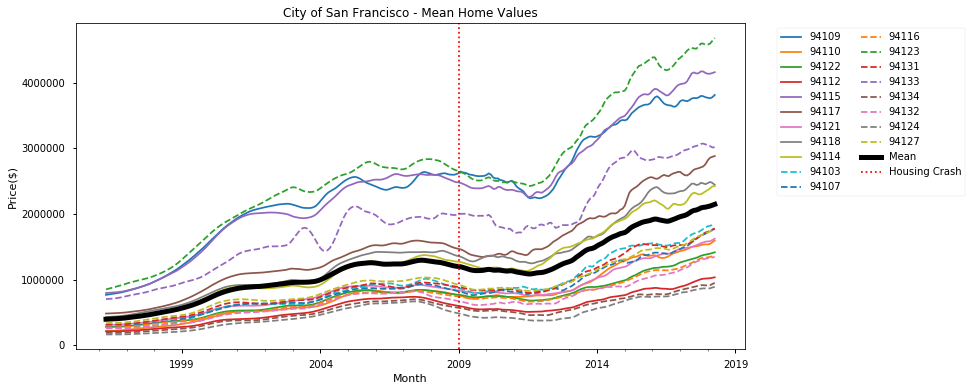

In [20]:
def plot_value(df_dict, col = 'MeanValue', zipcodes = []):
    '''This function takes in a dictionary and plots a list of values
       
       df_dict is the timeseries data in dictionary form
       col is the column to be plotted, default is a column called "MeanValue"
       zipcodes are the list of timeseries to be plotted '''
       
    if len(zipcodes) == 0:
        zipcodes = list(df_dict.keys())
        
        print(zipcodes)
        
        cutoff = len(zipcodes)//2
        
        fig,ax = plt.subplots(figsize = (12,6))
        
        ts_dict = {}
        for i,zc in enumerate(zipcodes):
            if i < cutoff:
                ls = '-'
            else:
                ls = '--'
                
            ts = df_dict[zc][col].rename(zc)
            ts.plot(label = str(zc), ax = ax, ls = ls)
            ts_dict[zc] = ts
            
        mean = pd.DataFrame(ts_dict).mean(axis = 1)
        mean.plot(label = 'Mean', lw = 5, color = 'black')
        
        crash = '01-2009'
        ax.axvline(crash, label = 'Housing Crash', color = 'red',ls = ':')
        
        ax.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left', ncol = 2)
        ax.set(title = 'City of San Francisco - Mean Home Values', ylabel = 'Price($)')
        
        return fig,ax, ts_dict
fig, ax, ts_dict = plot_value(sf_city)

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot


In [22]:
def plot_acf_pacf(ts, figsize = (10,8), lags = 20):
    '''The purpose of this function is to plot the ACF (Akaike Correlation Function)
    and the PACF Partial autocorrelation function from the timeseries dataframe'''
    
    
    fig,ax = plt.subplots(nrows = 3, figsize = figsize)
    ts.plot(ax=ax[0])
    plot_acf(ts, ax=ax[1], lags = lags)
    plot_pacf(ts, ax=ax[2], lags = lags)
    plt.tight_layout()
    
    plt.suptitle(f'Zipcode: {ts.name}', y=1.1, fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks = lags, integer = True))
        a.xaxis.grid()
              

In [23]:
zips = list(ts_dict.keys())
zips

[94109,
 94110,
 94122,
 94112,
 94115,
 94117,
 94121,
 94118,
 94114,
 94103,
 94107,
 94116,
 94123,
 94131,
 94133,
 94134,
 94132,
 94124,
 94127]

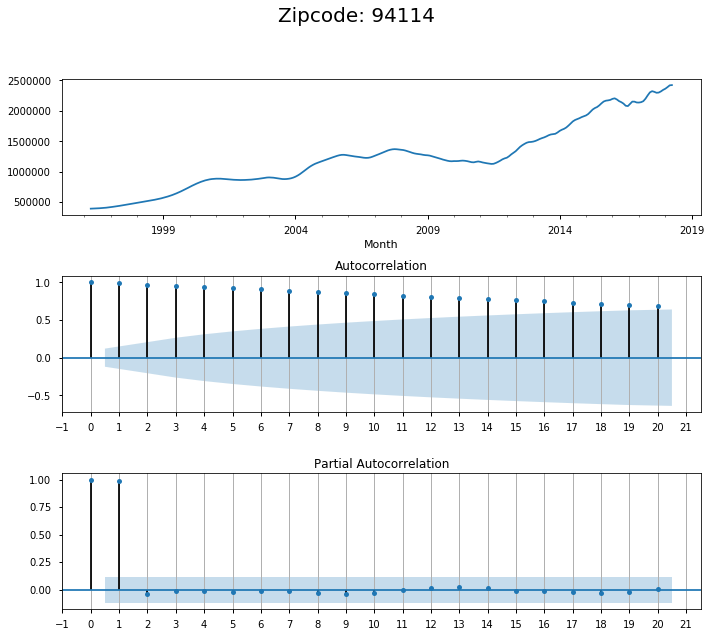

In [24]:
ts = ts_dict[np.random.choice(zips)]
plot_acf_pacf(ts)

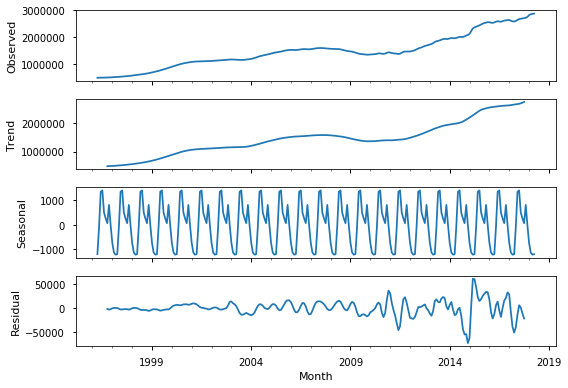

In [110]:
plt.style.use('seaborn-notebook')

seasonality = seasonal_decompose(ts)
seasonality.plot();
plt.tight_layout()

# Step 4: ARIMA Modeling

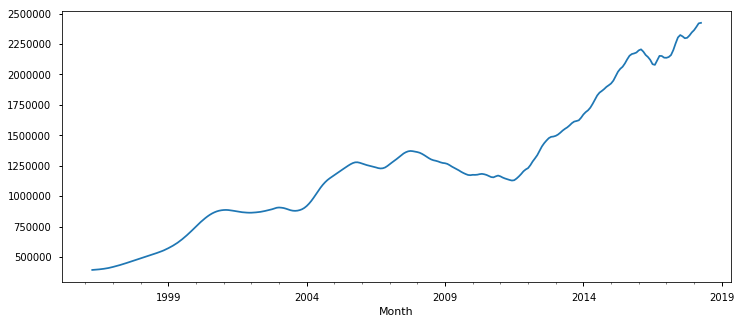

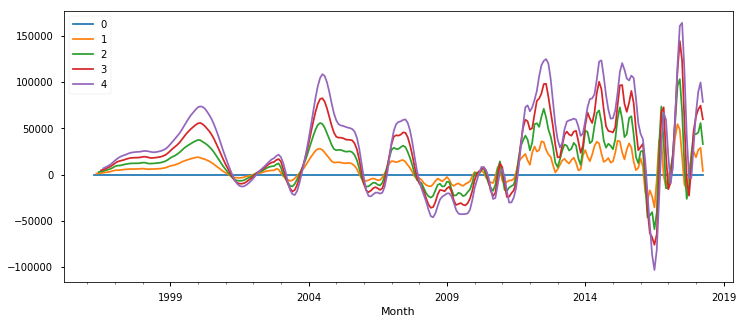

In [25]:
mpl.rcParams['figure.figsize'] = (12,5)
ts.plot()
plt.figure();
for i in range(5):
    ax = ts.diff(i).plot(label = i)
ax.legend();


In [26]:
def opt_pdq_pdqm(ps = [0,1,3], ds = [0,1,2,3], qs=[0,1,3], make_seasonal=True, m_values=[12]):
    import itertools
    
    params = {}
    params['pdq'] = list(itertools.product(ps, ds, qs, m_values))
    
    if make_seasonal:
        params['PDQM'] = list(itertools.product(ps,ds,qs,m_values))
    return params

def get_train_test_split_index(ts, TEST_SIZE= 0.1, min_test_ts = 2):
    import math
    idx_split = math.floor(len(ts.index) * (1 - TEST_SIZE))
    
    num_test_ts = len(ts.iloc[idx_split:])
    if num_test_ts < min_test_ts:
        print(f'Using TEST_SIZE produced {num_test_ts} test timestamps')
        print(f' - override TEST_SIZE and use min_test_ts instead')
        
        idx_split = len(ts) - min_test_ts
        
    return idx_split

def train_test_split_ts(ts, test_size = 0.2, min_test_ts = 2):
    idx_split = get_train_test_split_index(ts, TEST_SIZE = test_size,
                                          min_test_ts = min_test_ts)
    ts_train = ts.iloc[:idx_split]
    ts_test = ts.iloc[idx_split:]
    return ts_train, ts_test

def get_time(return_dt = True, return_str = True, show = False):
    import datetime as dt
    import tzlocal as tz
    now = dt.datetime.now(tz=tz.get_localzone())
    str_time = now.strftime('%m/%d/%Y - %I:%M:%S %p')
    if show:
        print(str_time)
        
    output = []
    if return_dt:
        output.append(now)
        
    if return_str:
        output.append(str_time)
        
        return output[:]
    
    
    
    
    

In [27]:
params = opt_pdq_pdqm()
print(params.keys())
print(params['pdq'][:10])
params['PDQM'][:10]

dict_keys(['pdq', 'PDQM'])
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 3, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 3, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 3, 12), (0, 3, 0, 12)]


[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 3, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 3, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 3, 12),
 (0, 3, 0, 12)]

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def grid_search_arima(ts_train, pdq = None, pdqm = None, order_dict = None, 
                   make_seasonal = False, verbose = False, model_kws={}):
    
    from tqdm import trange
    
    if (pdq is None) & (order_dict is not None):
        pdq = order_dict['pdq']
        
    if (pdqm is None) & (order_dict is not None):
        pdqm = order_dict['PDQM']
        
        
        start, start_str = get_time(return_dt = True, return_str = True)
        print(f'[i] Starting Grid Search @ {start_str}:')
        
        res = [['pdq', 'PDQM', 'AIC']]
        for i in trange((len(pdq))):
            comb = pdq[i]
            
            if make_seasonal:
                for combs in pdqm:
                    try: 
                        model = SARIMAX(ts_train, order = comb, 
                                       seasonal_order = combs, enforce_stationarity = False,
                                       enforce_invertibility = False, **model_kws)
                        output = model.fit()
                        res.append([comb, combs, output.aic])
                    except:
                        if verbose:
                            print(f'Error running ({comb})({combs})')
                        continue

            if make_seasonal == False:
                    try:
                        model = SARIMAX(ts_train, order = comb, enforce_stationarity = False,
                                   enforce_invertibility = False, **model_kws)

                        output = model.fit()
                        res.append([comb, 'N/A', output.aic])

                    except:
                        if verbose:
                            print(f' Error running ({comb} / {combs})')
                            continue

    end, end_str = get_time(return_dt = True, return_str = True)
    elapsed = end-start
    print(f' Grid Search finished at {end_str}')
    print(f' Total time: {elapsed}')
          
    try:
          df_res = fs.list2df(res)
          return df_res
          
    except:
          print(' Error converting to DF,  returning list')
          return res


In [29]:
ts = ts_dict[94123]
ts_train, ts_test = train_test_split_ts(ts, test_size =0.1)

len(ts_train), len(ts_test)


(238, 27)

In [30]:
res = grid_search_arima(ts_train, order_dict = params, make_seasonal = False)
res.sort_values('AIC', inplace=True)
res.head()

[i] Starting Grid Search @ 01/12/2020 - 01:02:06 PM:


100%|██████████| 36/36 [00:07<00:00,  2.75it/s]


 Grid Search finished at 01/12/2020 - 01:02:13 PM
 Total time: 0:00:07.047172


,pdq,PDQM,AIC
32,"(3, 2, 3, 12)",N/A,4767.698737
20,"(1, 2, 3, 12)",N/A,4781.219571
8,"(0, 2, 3, 12)",N/A,4782.024671
35,"(3, 3, 3, 12)",N/A,4791.148052
29,"(3, 1, 3, 12)",N/A,4792.339155


# Step 6: Interpreting Results

In [31]:
best_params = dict(order=res.iloc[0].loc['pdq'])
best_params

{'order': (3, 2, 3, 12)}

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  94123   No. Observations:                  238
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -2376.849
Date:                Sun, 12 Jan 2020   AIC                           4767.699
Time:                        13:02:19   BIC                           4791.826
Sample:                    04-01-1996   HQIC                          4777.429
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0832      0.227      0.366      0.714      -0.362       0.528
ar.L2         -0.5329      0.072     -7.412      0.000      -0.674      -0.392
ar.L3          0.2038      0.098      2.073      0.038       0.011       0.397
ma.L1          0.6020      0.236      2.545      0.011       0.138       1.066
ma.L2          0.2569      0.222      1.157      0.247      -0.178       0.692
ma.L3          0.0537      0.081      0.664      0.506      -0.105       0.212
sigma2      4.299e+07   2.06e-08   2.08e+15      0.000     4.3e+07     4.3e+07
===================================================================================
Ljung-Box (Q):                      146.86   Jarque-Bera (JB):               290.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              41.07   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.87e+30. Standard errors may be unstable.
"""

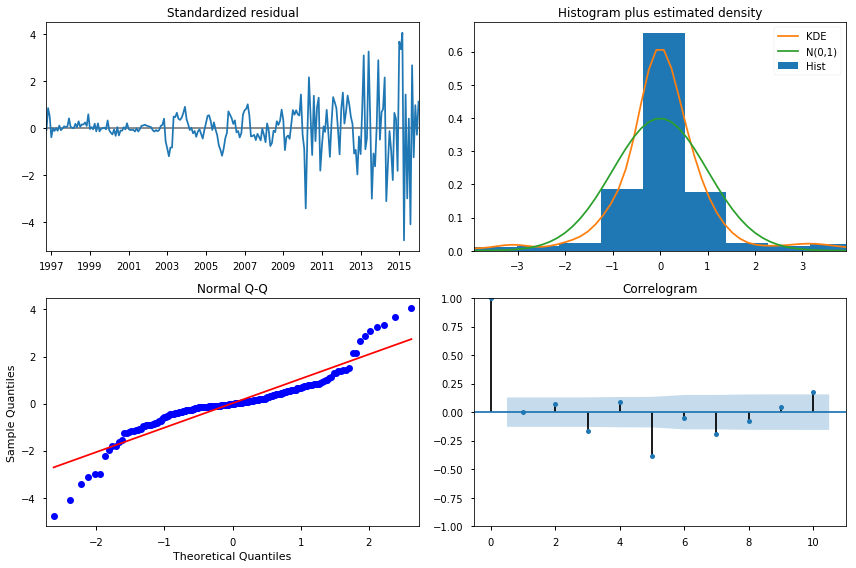

In [32]:
model_output = SARIMAX(ts_train, **best_params,
                      enforce_invertibility=False, 
                      enforce_stationarity=False).fit()
display(model_output.summary())
model_output.plot_diagnostics(figsize=(12,8));
plt.tight_layout()

# Model Evaluation Functions


In [33]:
def model_evaluation(ts_true, ts_pred, show=True, show_u_info=False):
    '''Evaluate the model with RMSE, R2, and Thiels U metrics and prints a pretty dataframe'''
    from sklearn.metrics import mean_squared_error, r2_score
    
    res = [['Metric','Value']]
    
    res.append(['RMSE', np.sqrt(mean_squared_error(ts_true, ts_pred))])
    res.append(['R2', r2_score(ts_true, ts_pred)])
    res.append(["Thiel's U", fs.jmi.thiels_U(ts_true, ts_pred,
              display_equation=show_u_info, 
              display_table = show_u_info)])
    res = fs.list2df(res)
    
    if show:
        display(res)
    return res

def expected_roi(investment, final_value):
    roi = np.round(((final_value - investment) / investment) *100, 3)
    return roi

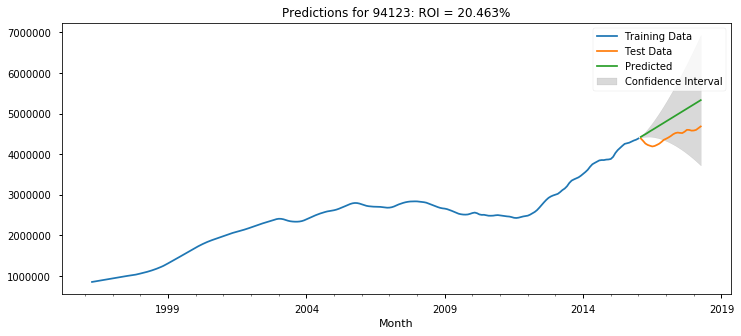

,Metric,Value
0,RMSE,471138.286046
1,R2,-8.503554
2,Thiel's U,14.050963


,lower 94123,upper 94123,predicted_mean
2016-02-01,4.411925e+06,4.437628e+06,4.424777e+06
2016-03-01,4.422153e+06,4.495800e+06,4.458976e+06
2016-04-01,4.426185e+06,4.555833e+06,4.491009e+06
2016-05-01,4.430961e+06,4.622613e+06,4.526787e+06
2016-06-01,4.431039e+06,4.695281e+06,4.563160e+06
2016-07-01,4.424009e+06,4.770280e+06,4.597144e+06
2016-08-01,4.414350e+06,4.848403e+06,4.631377e+06
2016-09-01,4.403197e+06,4.930850e+06,4.667024e+06
2016-10-01,4.388128e+06,5.016211e+06,4.702169e+06
2016-11-01,4.369383e+06,5.103756e+06,4.736570e+06


In [34]:
def get_model_preds_df(model_output, ts_train, ts_test, start=None, end=None, get_metrics = True):
    
    if start is None:
        start = ts_test.index[0]
        
    if end is None:
        end = ts_test.index[-1]
        
    prediction = model_output.get_prediction(start=start, end=end, dynamic=True)
    
    preds_df = prediction.conf_int()
    preds_df['predicted_mean'] = prediction.predicted_mean
    plot_df = pd.concat([preds_df, ts_train], axis=1)
    
    roi = expected_roi(preds_df['predicted_mean'].iloc[0], preds_df['predicted_mean'].iloc[-1])
    
    zc = ts_train.name
    
    fig, ax = plt.subplots()
    ts_train.plot(ax=ax, label= 'Training Data')
    ts_test.plot(ax=ax, label='Test Data')
    
    #preds_df['predicted_mean'].plot(ax=ax)
    
    ax.fill_between(preds_df.index, preds_df[f'lower {zc}'],
                   preds_df[f'upper {zc}'], color="k", alpha=0.15,
                    label = 'Confidence Interval')
    
    prediction.predicted_mean.plot(ax=ax, label='Predicted')
    
    ax.legend()
    
    ax.set(title=f"Predictions for {zc}: ROI = {roi}%")
    
    fig = ax.get_figure()
    
    plot_df['zipcode'] = ts_train.name
    plt.show()
    
    if get_metrics:
        res = model_evaluation(ts_test, preds_df["predicted_mean"])
    return preds_df, fig,ax

preds_df, fig,ax = get_model_preds_df(model_output, ts_train, ts_test)
preds_df

# Grid Search for all zipcodes in the county


[94109, 94110, 94122, 94112, 94115, 94117, 94121, 94118, 94114, 94103, 94107, 94116, 94123, 94131, 94133, 94134, 94132, 94124, 94127]


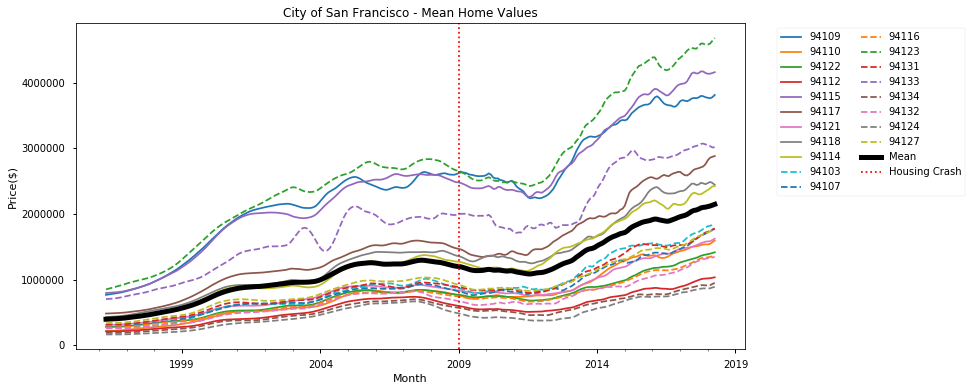

In [35]:
fig,ax,ts_dict = plot_value(sf_city)

In [36]:
print(ts.index[0])
ts.index[0] + pd.to_timedelta(1,'MS')
end=ts.index[0] + pd.to_timedelta(1,'MS')
pd.to_datetime(end)

1996-04-01 00:00:00


Timestamp('1996-04-01 00:00:00.001000', freq='MS')



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94109
[i] Starting Grid Search @ 01/12/2020 - 01:02:34 PM:


100%|██████████| 36/36 [00:09<00:00,  2.02it/s]


 Grid Search finished at 01/12/2020 - 01:02:44 PM
 Total time: 0:00:09.913474
Best Params {'order': (3, 2, 3, 12)}


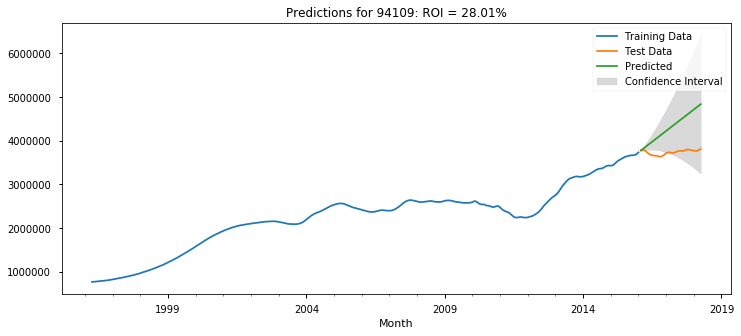

,Metric,Value
0,RMSE,641154.543431
1,R2,-146.159924
2,Thiel's U,29.384832




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94110
[i] Starting Grid Search @ 01/12/2020 - 01:02:45 PM:


100%|██████████| 36/36 [00:11<00:00,  1.10s/it]


 Grid Search finished at 01/12/2020 - 01:02:57 PM
 Total time: 0:00:11.983966
Best Params {'order': (3, 3, 3, 12)}


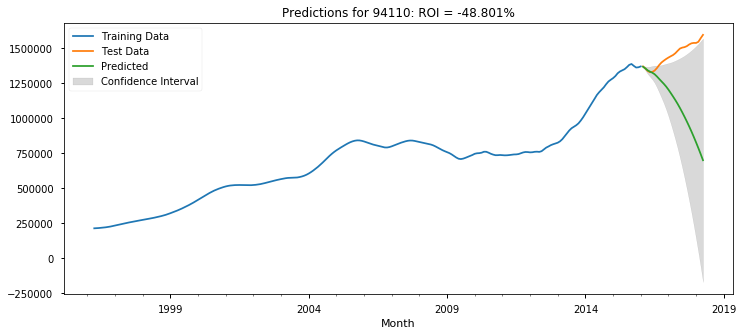

,Metric,Value
0,RMSE,440406.241050
1,R2,-28.971474
2,Thiel's U,31.375860




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94122
[i] Starting Grid Search @ 01/12/2020 - 01:03:02 PM:


100%|██████████| 36/36 [00:10<00:00,  2.61it/s]


 Grid Search finished at 01/12/2020 - 01:03:12 PM
 Total time: 0:00:10.537307
Best Params {'order': (3, 1, 3, 12)}


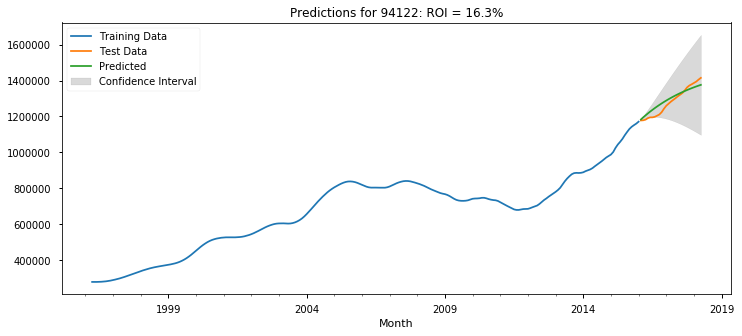

,Metric,Value
0,RMSE,29631.528315
1,R2,0.859072
2,Thiel's U,3.060886




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94112
[i] Starting Grid Search @ 01/12/2020 - 01:03:13 PM:


100%|██████████| 36/36 [00:08<00:00,  2.93it/s]


 Grid Search finished at 01/12/2020 - 01:03:22 PM
 Total time: 0:00:08.655870
Best Params {'order': (3, 2, 0, 12)}


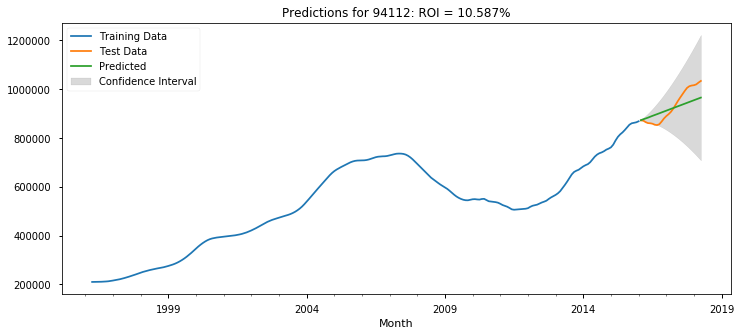

,Metric,Value
0,RMSE,41122.307280
1,R2,0.605597
2,Thiel's U,4.427635




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94115
[i] Starting Grid Search @ 01/12/2020 - 01:03:22 PM:


100%|██████████| 36/36 [00:11<00:00,  2.03it/s]


 Grid Search finished at 01/12/2020 - 01:03:34 PM
 Total time: 0:00:11.735797
Best Params {'order': (3, 2, 3, 12)}


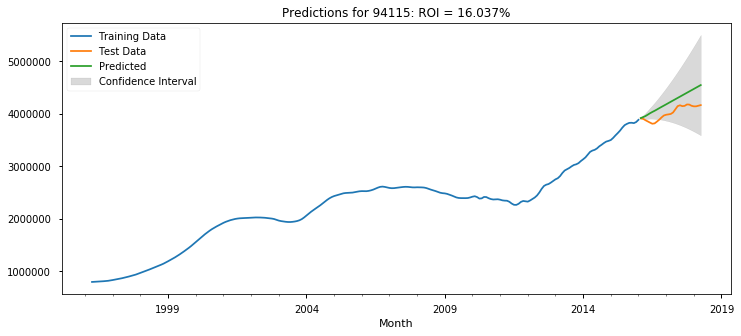

,Metric,Value
0,RMSE,230126.853392
1,R2,-2.105698
2,Thiel's U,8.612528




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94117
[i] Starting Grid Search @ 01/12/2020 - 01:03:35 PM:


100%|██████████| 36/36 [00:14<00:00,  2.05s/it]


 Grid Search finished at 01/12/2020 - 01:03:50 PM
 Total time: 0:00:14.444483
Best Params {'order': (3, 2, 3, 12)}


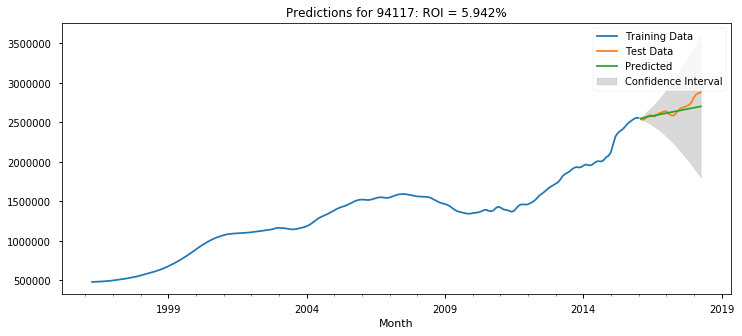

,Metric,Value
0,RMSE,68670.782454
1,R2,0.520162
2,Thiel's U,2.883054




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94121
[i] Starting Grid Search @ 01/12/2020 - 01:03:52 PM:


100%|██████████| 36/36 [00:13<00:00,  1.27it/s]


 Grid Search finished at 01/12/2020 - 01:04:05 PM
 Total time: 0:00:13.349149
Best Params {'order': (3, 3, 3, 12)}


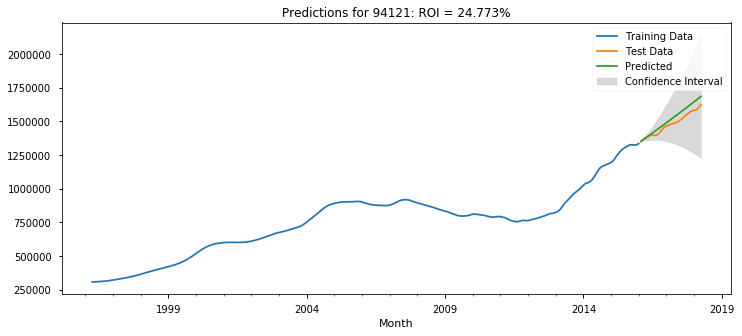

,Metric,Value
0,RMSE,43925.281864
1,R2,0.691414
2,Thiel's U,3.606351




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94118
[i] Starting Grid Search @ 01/12/2020 - 01:04:06 PM:


100%|██████████| 36/36 [00:15<00:00,  1.22s/it]


 Grid Search finished at 01/12/2020 - 01:04:22 PM
 Total time: 0:00:15.919292
Best Params {'order': (3, 1, 3, 12)}


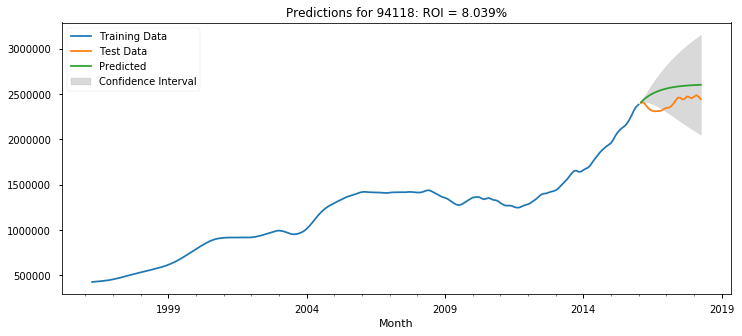

,Metric,Value
0,RMSE,162532.746786
1,R2,-6.076553
2,Thiel's U,8.898741




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94114
[i] Starting Grid Search @ 01/12/2020 - 01:04:23 PM:


 92%|█████████▏| 33/36 [00:13<00:01,  1.66it/s]

In [ ]:
params = opt_pdq_pdqm()

ts_resdict = {}
for zc,ts in ts_dict.items():
    print("\n")
    print('---'*30)
    print('---'*30)
    print(f'Zipcode: {zc}')
    
    # Train Test Split
    ts_train, ts_test = train_test_split_ts(ts, test_size=0.1)
    
    # Grid Search
    res = grid_search_arima(ts_train, order_dict = params, make_seasonal = False)
    res.sort_values('AIC', inplace=True)
    best_params = dict(order=res.iloc[0].loc['pdq'])
    
    ts_resdict[zc] = {}
    ts_resdict[zc]['res'] = res
    ts_resdict[zc]['best_params'] = best_params
    print('Best Params', best_params)
    
    model_output = SARIMAX(ts_train, **best_params, 
                          enforce_invertibility = False,
                          enforce_stationarity = False).fit()
    
    
    ts_resdict[zc]['model'] = model_output
    
    preds_df,fig,ax = get_model_preds_df(model_output, ts_train, ts_test)
    ts_resdict[zc]['preds_df'] = preds_df
    
    
    
    

# Forecast for the model

In [ ]:
params = opt_pdq_pdqm()

ts_resdict = {}
for zc,ts in ts_dict.items():
    print('\n')
    print('***'*30)
    print('***'*30)
    print(f'Zipcode {zc}')
    
    ts_train, ts_test = train_test_split_ts(ts, test_size = 0.1)
    
    res = grid_search_arima(ts_train, order_dict = params, make_seasonal = False)
    res.sort_values('AIC', inplace = True)
    best_params = dict(order=res.iloc[0].loc['pdq'])
    
    ts_resdict[zc] = {}
    ts_resdict[zc]['res'] = res
    ts_resdict[zc]['best_params'] = best_params
    print('Best Params', best_params)
    
    model_output = SARIMAX(ts, **best_params, 
                          enforce_invertibility = False,
                          enforce_stationarity = False).fit()
    
    ts_resdict[zc]['model'] = model_output

    preds_df, fig, ax, = get_model_preds_df(model_output, ts_train, ts_test,
                                           start = ts.index[-1], 
                                           end = ts.index.shift(12)[-1], get_metrics = False)
    ts_resdict[zc]['preds_df'] = preds_df
    
    


# 